# **Fourier Transforms and Plane-Wave Expansions**

Authors:Guoyuan Liu, Dou Du and Giovanni Pizzi

<i class="fa fa-home fa-2x"></i><a href="../index.ipynb" style="font-size: 20px"> Go back to index</a>

**Source code:** https://github.com/osscar-org/quantum-mechanics/blob/master/notebook/band-theory/FFT_and_planewaves.ipynb

This notebook shows interactively how a discrete Fourier series can be used to represent a function with a limited number of plane-wave components. A common way to represent a wavefunction when solving the Kohn-Sham equations for a periodic solid is via its expansion in plane waves.
This notebook focuses on a simple example (much simpler than a complete DFT calculation) in order to help the reader focus on the essential aspects of such a representation.

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

## **Goals**

* Understand how a plane-wave basis is directly related to a Fourier series.
* Learn how to decompose a function using an FFT algorithm.
* Examine how a function is reconstructed from a finite (possibly not complete) set of plane waves.
* Understand the impact of the basis-set size on the convergence of the integral of the reconstructed function.

## **Background theory** 

[More on the background theory.](./theory/theory_fft.ipynb)

## **Tasks and exercises**

<ol>
<li>Background theory: prove that plane waves form an orthogonal basis set.
<details>
    <summary style="color: red">Solution</summary>
    
We have to prove that $\langle w_N^j, w_N^k \rangle =\langle w_N^k, w_N^j \rangle= 0 $ for integer $j \neq k$. We can simply carry out the inner product       
$$ \langle w_N^j, w_N^k \rangle = \langle w_N^k, w_N^j \rangle = \int_{-\pi}^{\pi} e^{ijx} e^{-ikx}dx = \int_{-\pi}^{\pi} e^{i(j-k)x} dx = \frac 1 {i(j-k)} [e^{i(j-k)x}]_{-\pi}^{\pi} = \begin{cases} 0 & \text{if j $\neq$ k} \\ 2\pi & \text{if j = k}\end{cases}$$
</details></li>

<li>How does the number of plane waves affect the approximation of the target function? Move the $N_{fft}$ slider to modify the number of Fourier components used in the approximation. Will a function with more "oscillations" require more components to be accurately represented? You can change the objective function (from a relatively smooth function to a more oscillatory one) via the drop-down menu.
<details>
    <summary style="color: red">Solution</summary>
Observe whether the FFT interpolation approximates well the original function and if the integral of the square modulus is close to the converged value indicated by the red horizontal line. Generally, increased sampling yields a more accurate representation of the objective function.
For functions with more oscillations (higher frequency components), more Fourier components are needed to reach the same level of accuracy.
</details></li>

<li>Background theory: how can we reduce the number of plane waves needed in a DFT calculation, without sacrificing the accuracy of the representation?
<details>
    <summary style="color: red">Solution</summary>

Wavefunctions have the strongest oscillations near nucleus, and a very large number of plane waves is needed to accurately represent this region. Fortunately, core electrons are less relevant in chemical bonding, so we can simplify the problem and obtain a much smoother (pseudo)wavefunction by excluding the core electrons. To learn more about this approach, please check our <a href="./pseudopotential.ipynb">notebook on pseudopotentials</a>. In general, the combination of pseudopotentials and a plane-wave expansion enables fast and accurate calculation of materials and their properties.
</details></li>

<li>Background theory: in a DFT calculation, how can we control the number of plane waves used in the basis set?
<details>
    <summary style="color: red">Solution</summary>
  
The kinetic energy of a plane wave of momentum $\mathbf G$ is given by $\frac {\hbar^2}{2m} \lvert \mathbf G \rvert^2$. By setting a cutoff energy, we can limit the size of the plane-wave basis set. The value of the required cutoff depends on the system under investigation and the pseudopotential used. Convergence tests are normally required to gain confidence in the value of the cutoff employed. To have a suggestion of a converged cutoff value based on the choice of pseudopotentials, you can check the <a href="https://www.materialscloud.org/discover/sssp/table/precision">standard solid-state pseudopotentials (SSSP) library</a> on Materials Cloud.
</details></li>
</ol>

<hr style="height:1px;border:none;color:#cccccc;background-color:#cccccc;" />

## Interactive visualization
(be patient, it might take a few seconds to load)

In [1]:
import ipywidgets as ipw
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib widget
plt.rcParams['figure.autolayout'] = 'True' # turn on tight layout globally

In [2]:
# target functions
def periodic_f(x):
    # smooth
    return np.exp(-((x-1)/0.15)**2) + 0.5 * np.exp(-((x-1.2)/0.1)**2) + 0.8 * np.exp(-((x-0.8)/0.1)**2)

def periodic_f2(x):
    # less smooth
    return np.exp(-((x-1)/0.05)**2) -0.5*np.exp(-((x-1)/0.15)**2) + 0.5 * np.exp(-((x-1.2)/0.1)**2) + 0.8 * np.exp(-((x-0.8)/0.1)**2)

In [3]:
# plot x range
x = np.linspace(0, 2, 201, endpoint=False)
x_range = 2

# widgets
N_slider = ipw.IntSlider(description=r"$N_{\text{fft}}$", min=6, max=40, value=6, step=1, continuous_update=False, layout={'margin':'0px 15px 0px 15px'})
func_dropdown=ipw.Dropdown(description="Function", options=[("Smooth", "periodic_f"), ("Less smooth", "periodic_f2")], layout={ 'margin':'0px 15px 0px 15px'})
reset_button = ipw.Button(description='Show all', icon='redo',  style={'description_width': 'initial'}, layout={'width':'220px', 'margin':'0px 20px 0px 60px'})
hl_label = ipw.Label(value='(click on a FFT component to select it)')

In [4]:
def compute_resampled(N_fft, x_range=2., function=periodic_f):
    """ Compute FFT series with given number of sampling and target functions. """
    # Pick an even number to have zero
    x_fft = np.linspace(0, x_range, N_fft+1, endpoint=False)# remove last point as it's the same as the first one by PBC
    y_fft = function(x_fft)
    # Fourier resampling
    renormalization = len(x)/(len(y_fft))
    y_resamp = fft.irfft(fft.rfft(y_fft), len(x)) * renormalization
    
    return x_fft, y_fft, y_resamp

def get_integral_resampled(N_fft, x_range=2., function=periodic_f):
    """ Compute the integral of the square modulus of the function. """ 
    x_fft, y_fft, _ = compute_resampled(N_fft, x_range, function=function)
    return (y_fft**2).sum() * (x_fft[1] - x_fft[0])

def plot_reconstruct(y_fft):
    """ Plot Fourier expansions """
    ax2.clear()

    coeffs = fft.rfft(y_fft)
    N_rfft = 0 # number of fft expansions
    for coeff, freq_int in list(zip(coeffs, range(len(coeffs)))):
        freq = 2 * np.pi * freq_int / x_range
        norm = 1 / (len(y_fft)) * 2
        if freq_int == 0:
            # The zero-frequency does not have a factor 2 because it's not a cosine
            # summing the two complex conjugates, but just a constant
            norm /= 2
        this_frequency_contrib = ( coeff.real * np.cos(freq * x) - coeff.imag * np.sin(freq * x) ) * norm

        ax2.plot(x, this_frequency_contrib + N_rfft) # plot components with vertical shift for visibility
        # ax2.plot(x, this_frequency_contrib) # no shift
        N_rfft += 1

    ax2.axes.yaxis.set_ticks([]) # remove y ticks
    ax2.set_title('Basis functions')

CONVERGE_SMOOTH = get_integral_resampled(N_fft=200, function=periodic_f)
CONVERGE_ROUGH = get_integral_resampled(N_fft=200, function=periodic_f2)
def plot_integral(func_name, func):
    """ plot sum of the square modulus (integral) """
    ax3.clear()
    converged_integral = CONVERGE_SMOOTH if func_name == "periodic_f" else CONVERGE_ROUGH
    ax3.axhline(converged_integral, color='tab:red')
    integrals = []
    for N in range(6, 41):
        integrals.append((N, get_integral_resampled(N, function=func)))
    integrals_x, integrals_y = np.array(integrals).T
    
    ax3.plot(integrals_x, integrals_y, 'o--', alpha=0.8)
    ax3.plot(integrals_x[N_fft-6], integrals_y[N_fft-6],'ro', markersize=11, label='current sampling')
    ax3.set_xlabel('number of components')
    ax3.set_ylabel("Integral of square modulus")
    ax3.set_title("Convergence of FFT")
    ax3.set_xlim(6,40)
    ax3.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.legend(loc='best')

def plot_sampling(func, x_fft, y_fft, y_resamp):
    ax1.clear()
    ax1.set_title('FFT interpolation')

    x_fft, y_fft, y_resamp = compute_resampled(N_slider.value, function=func)
    ax1.plot(x, func(x), 'k-', label='target')
    ax1.plot(x_fft, y_fft, 'o', label='sampling')
    ax1.fill_between(x, y_resamp, 0,ec='red', fc='yellow', label='FFT')
    ax1.legend(loc='best')
    ax1.set_ylim(-0.35,1.25)

def on_plot_click(event):
    """handle mouse click event on expansion component plot"""
    # line = event.artist
    # xdata = line.get_xdata()
    # ydata = line.get_ydata()
    if event.inaxes != ax2:
        return
    for i in range(len(ax2.lines)):
        ax2.lines[i].set_alpha(0.1)
        ax2.lines[i].set_linewidth(1.1)

    # get the id of the line2D object which is vertically closest to the mouse clicking position 
    id_line = min(enumerate(ax2.lines), key= lambda line: abs(np.mean(line[1].get_ydata())-event.ydata))[0]
    ax2.lines[id_line].set_alpha(1)
    ax2.lines[id_line].set_linewidth(2.0)

    plot_sampling(func, x_fft, y_fft, y_resamp)
    ax1.fill_between(ax2.lines[id_line].get_xdata(), ax2.lines[id_line].get_ydata()-id_line, 0, ec='tab:blue', fc='tab:green', alpha=0.5,label='component')
    ax1.legend()

def plot_update(change):
    # get current widget value
    global N_fft, x_fft, y_fft, y_resamp, func
    N_fft = N_slider.value
    func = globals()[func_dropdown.value] # get the function by function name
    x_fft, y_fft, y_resamp = compute_resampled(N_fft, function=func)
    # update sampling plot
    plot_sampling(func, x_fft, y_fft, y_resamp)

    # update reconstruct plot
    plot_reconstruct(y_fft)

    # udpate square modulus plot
    plot_integral(func_dropdown.value, func)


N_slider.observe(plot_update, names='value', type='change')
func_dropdown.observe(plot_update, names='value', type='change')
reset_button.on_click(plot_update)

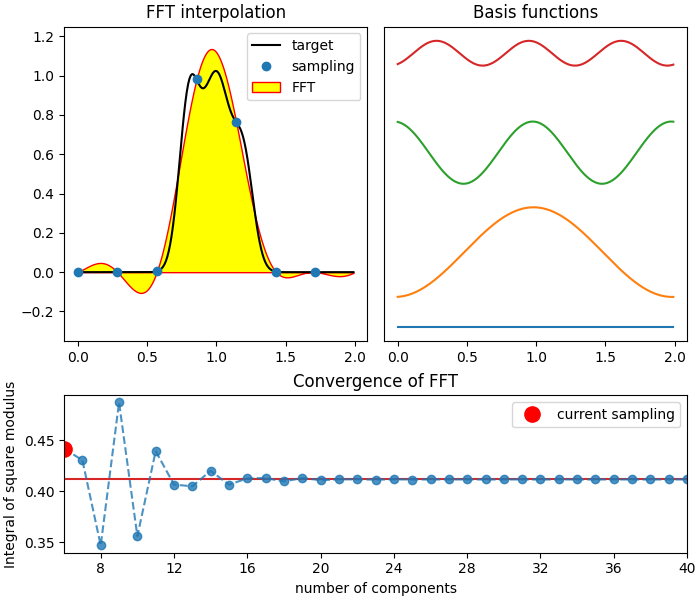

In [5]:
# define layout by gridspec
fig = plt.figure(constrained_layout=True, figsize=(7, 6))
gs = fig.add_gridspec(3,4)
ax1 = fig.add_subplot(gs[0:2,0:2])
ax2 = fig.add_subplot(gs[0:2,2:4])
ax3 = fig.add_subplot(gs[-1,:])

# interactive plot 2 for line picking
cid = fig.canvas.mpl_connect('button_press_event', on_plot_click)
# show plots
plot_update(None)
plt.show()



In [6]:
# display widgets
display(ipw.HBox([N_slider, func_dropdown]))
display(ipw.HBox([reset_button, hl_label]))

## Interactive Figures

The target function, sampling points and the reconstructed function are shown in the top left plot. The real part (cosine functions) and the constant term of the discrete Fourier series are shown in the top right panel.
    
Note that the components are shifted vertically for clarity. The integral of the square of the functions reconstructed from truncated Fourier series with different numbers of plane waves $N_{\text{fft}}$ is shown in the bottom panel, where the current choice of sampling is indicated with a red dot. The converged value is also shown with a red horizontal line, obtained with a large number (200) of FFT components. 

## Controls

The number of FFT components $N_{\text{fft}}$ can be set by the slider. 
Two target functions can be chosen from the drop-down menu.
By clicking on one of the basis functions in the top-right panel, the contribution of that basis function will be shown in the top left panel. One can click the reset button to display all basis functions again.